# Финальный проект

**Исполнитель:** Ивашкин Дмитрий


**Условие:**

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

* В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
* Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
* Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.




### Подготовка библиотек для анализа:

In [1]:
# Импорт необходимых нам библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import datetime
from datetime import date
import scipy.stats as ss
from tqdm.auto import tqdm
from scipy.stats import shapiro, mannwhitneyu, norm

# Импорт библиотек для загрузки файлов с Яндекс диска
import requests
from urllib.parse import urlencode

%matplotlib inline

In [50]:
# Задаём параметры графиков:
plt.rcParams['figure.figsize'] = (16, 8)

# Задание 1: 
**1.1 Условие**

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared и имеют следующую структуру:

* `shared/problem1-reg_data.csv` – данные о времени регистрации

|auth_ts| uid|
|------|------|
| 906166566 | 2 |
| 906344325	| 2 |
| 906686169	| 2 |
| 906893386	| 2 |
| 906980227	| 2 |



* `shared/problem1-auth_data.csv` – данные о времени захода пользователей в игру

|reg_ts | uid|
|------|------|
| 906166566	|2|
| 924422172	|3|
| 937374732	|4|
| 947425117	|5|
| 955630339	|6|

Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

## Подготовка к анализу данных

#### Загружаем данные:

In [51]:
path_auth = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-ivashkin-23/shared/problem1-auth_data.csv'
path_reg = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-ivashkin-23/shared/problem1-reg_data.csv'

In [52]:
# данные о времени регистрации
df_reg = pd.read_csv(path_reg, sep=';')

In [53]:
df_reg.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [54]:
# посмотрим информацию о данных
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [58]:
# суммарное количество пропусков в каждом столбце
df_reg.isna().sum()

reg_ts    0
uid       0
reg_dt    0
dtype: int64

In [59]:
# приведём время из timestamp в дату
df_reg['reg_dt'] = pd.to_datetime(
        df_reg.reg_ts, unit='s').dt.date

In [60]:
# данные о времени регистрации
df_auth = pd.read_csv(path_auth, sep=';')

In [61]:
df_auth.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [62]:
# посмотрим информацию о данных
df_auth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [63]:
# суммарное количество пропусков в каждом столбце
df_auth.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [64]:
# приведём время из timestamp в дату
df_auth['auth_dt'] = pd.to_datetime(
        df_auth.auth_ts, unit='s').dt.date

#### Объединим данные:

In [80]:
full_df = df_reg.merge(df_auth, on='uid')
# посчитаем разницу дат между регистрацией пользователя и заходом в игру
full_df['timedelta'] = (full_df.auth_dt - 
                            full_df.reg_dt).dt.days

In [81]:
# посмотрим минимальные даты:
full_df[['reg_dt', 'auth_dt']].min()

reg_dt     1998-11-18
auth_dt    1998-11-18
dtype: object

In [82]:
# посмотрим максимальные даты:
full_df[['reg_dt', 'auth_dt']].max()

reg_dt     2020-09-23
auth_dt    2020-09-23
dtype: object

In [90]:
# Задаём период анализа:
start_date = datetime.date(2020, 1, 1)
end_date = datetime.date(2020, 2, 1)

In [91]:
# Создадим датафрейм с заданным периодом анализа:
full_df_dt = full_df.query(
        'reg_dt >= @start_date and auth_dt <= @end_date')

In [92]:
# Создадим таблицу для когортного анализа, за когорты будем считать день регистрации пользователя:
cohort = (
        full_df_dt.groupby(['reg_dt','timedelta'], 
                        as_index=False)
          .agg({'uid':'nunique'})
          .pivot(index='reg_dt', 
                 columns='timedelta', 
                 values='uid')
    )
cohort

timedelta,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
reg_dt,,,,,,,,,,,,,,,,,,,,,
2020-01-01,1061.0,28.0,48.0,36.0,60.0,62.0,80.0,53.0,47.0,47.0,...,37.0,29.0,40.0,33.0,42.0,38.0,35.0,35.0,25.0,33.0
2020-01-02,1063.0,25.0,48.0,55.0,51.0,62.0,82.0,63.0,60.0,56.0,...,46.0,44.0,36.0,40.0,36.0,33.0,36.0,33.0,30.0,NaN
2020-01-03,1065.0,25.0,36.0,47.0,48.0,73.0,80.0,58.0,48.0,45.0,...,40.0,33.0,34.0,40.0,38.0,27.0,26.0,31.0,NaN,NaN
2020-01-04,1067.0,16.0,48.0,54.0,57.0,61.0,75.0,58.0,45.0,52.0,...,38.0,34.0,34.0,28.0,27.0,29.0,24.0,NaN,NaN,NaN
2020-01-05,1069.0,21.0,48.0,49.0,47.0,51.0,84.0,56.0,42.0,58.0,...,36.0,41.0,37.0,40.0,34.0,39.0,NaN,NaN,NaN,NaN
2020-01-06,1070.0,31.0,48.0,53.0,41.0,50.0,71.0,63.0,56.0,54.0,...,43.0,38.0,31.0,35.0,33.0,NaN,NaN,NaN,NaN,NaN
2020-01-07,1072.0,20.0,52.0,47.0,69.0,54.0,91.0,55.0,61.0,57.0,...,42.0,46.0,41.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,1074.0,24.0,43.0,46.0,55.0,54.0,91.0,54.0,48.0,67.0,...,38.0,44.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-09,1076.0,20.0,43.0,59.0,48.0,65.0,72.0,61.0,55.0,51.0,...,35.0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
# и посчитаем retention
retention_table = cohort.div(cohort[0], axis=0)
retention_table

timedelta,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
reg_dt,,,,,,,,,,,,,,,,,,,,,
2020-01-01,1.0,0.026390,0.045240,0.033930,0.056550,0.058435,0.075401,0.049953,0.044298,0.044298,...,0.034873,0.027333,0.037700,0.031103,0.039585,0.035815,0.032988,0.032988,0.023563,0.031103
2020-01-02,1.0,0.023518,0.045155,0.051740,0.047977,0.058325,0.077140,0.059266,0.056444,0.052681,...,0.043274,0.041392,0.033866,0.037629,0.033866,0.031044,0.033866,0.031044,0.028222,NaN
2020-01-03,1.0,0.023474,0.033803,0.044131,0.045070,0.068545,0.075117,0.054460,0.045070,0.042254,...,0.037559,0.030986,0.031925,0.037559,0.035681,0.025352,0.024413,0.029108,NaN,NaN
2020-01-04,1.0,0.014995,0.044986,0.050609,0.053421,0.057170,0.070291,0.054358,0.042174,0.048735,...,0.035614,0.031865,0.031865,0.026242,0.025305,0.027179,0.022493,NaN,NaN,NaN
2020-01-05,1.0,0.019645,0.044902,0.045837,0.043966,0.047708,0.078578,0.052385,0.039289,0.054256,...,0.033676,0.038354,0.034612,0.037418,0.031805,0.036483,NaN,NaN,NaN,NaN
2020-01-06,1.0,0.028972,0.044860,0.049533,0.038318,0.046729,0.066355,0.058879,0.052336,0.050467,...,0.040187,0.035514,0.028972,0.032710,0.030841,NaN,NaN,NaN,NaN,NaN
2020-01-07,1.0,0.018657,0.048507,0.043843,0.064366,0.050373,0.084888,0.051306,0.056903,0.053172,...,0.039179,0.042910,0.038246,0.032649,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,1.0,0.022346,0.040037,0.042831,0.051210,0.050279,0.084730,0.050279,0.044693,0.062384,...,0.035382,0.040968,0.029795,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-09,1.0,0.018587,0.039963,0.054833,0.044610,0.060409,0.066914,0.056691,0.051115,0.047398,...,0.032528,0.035316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Визуализируем полученные результаты:

Text(0.5, 339.0, 'Дни')

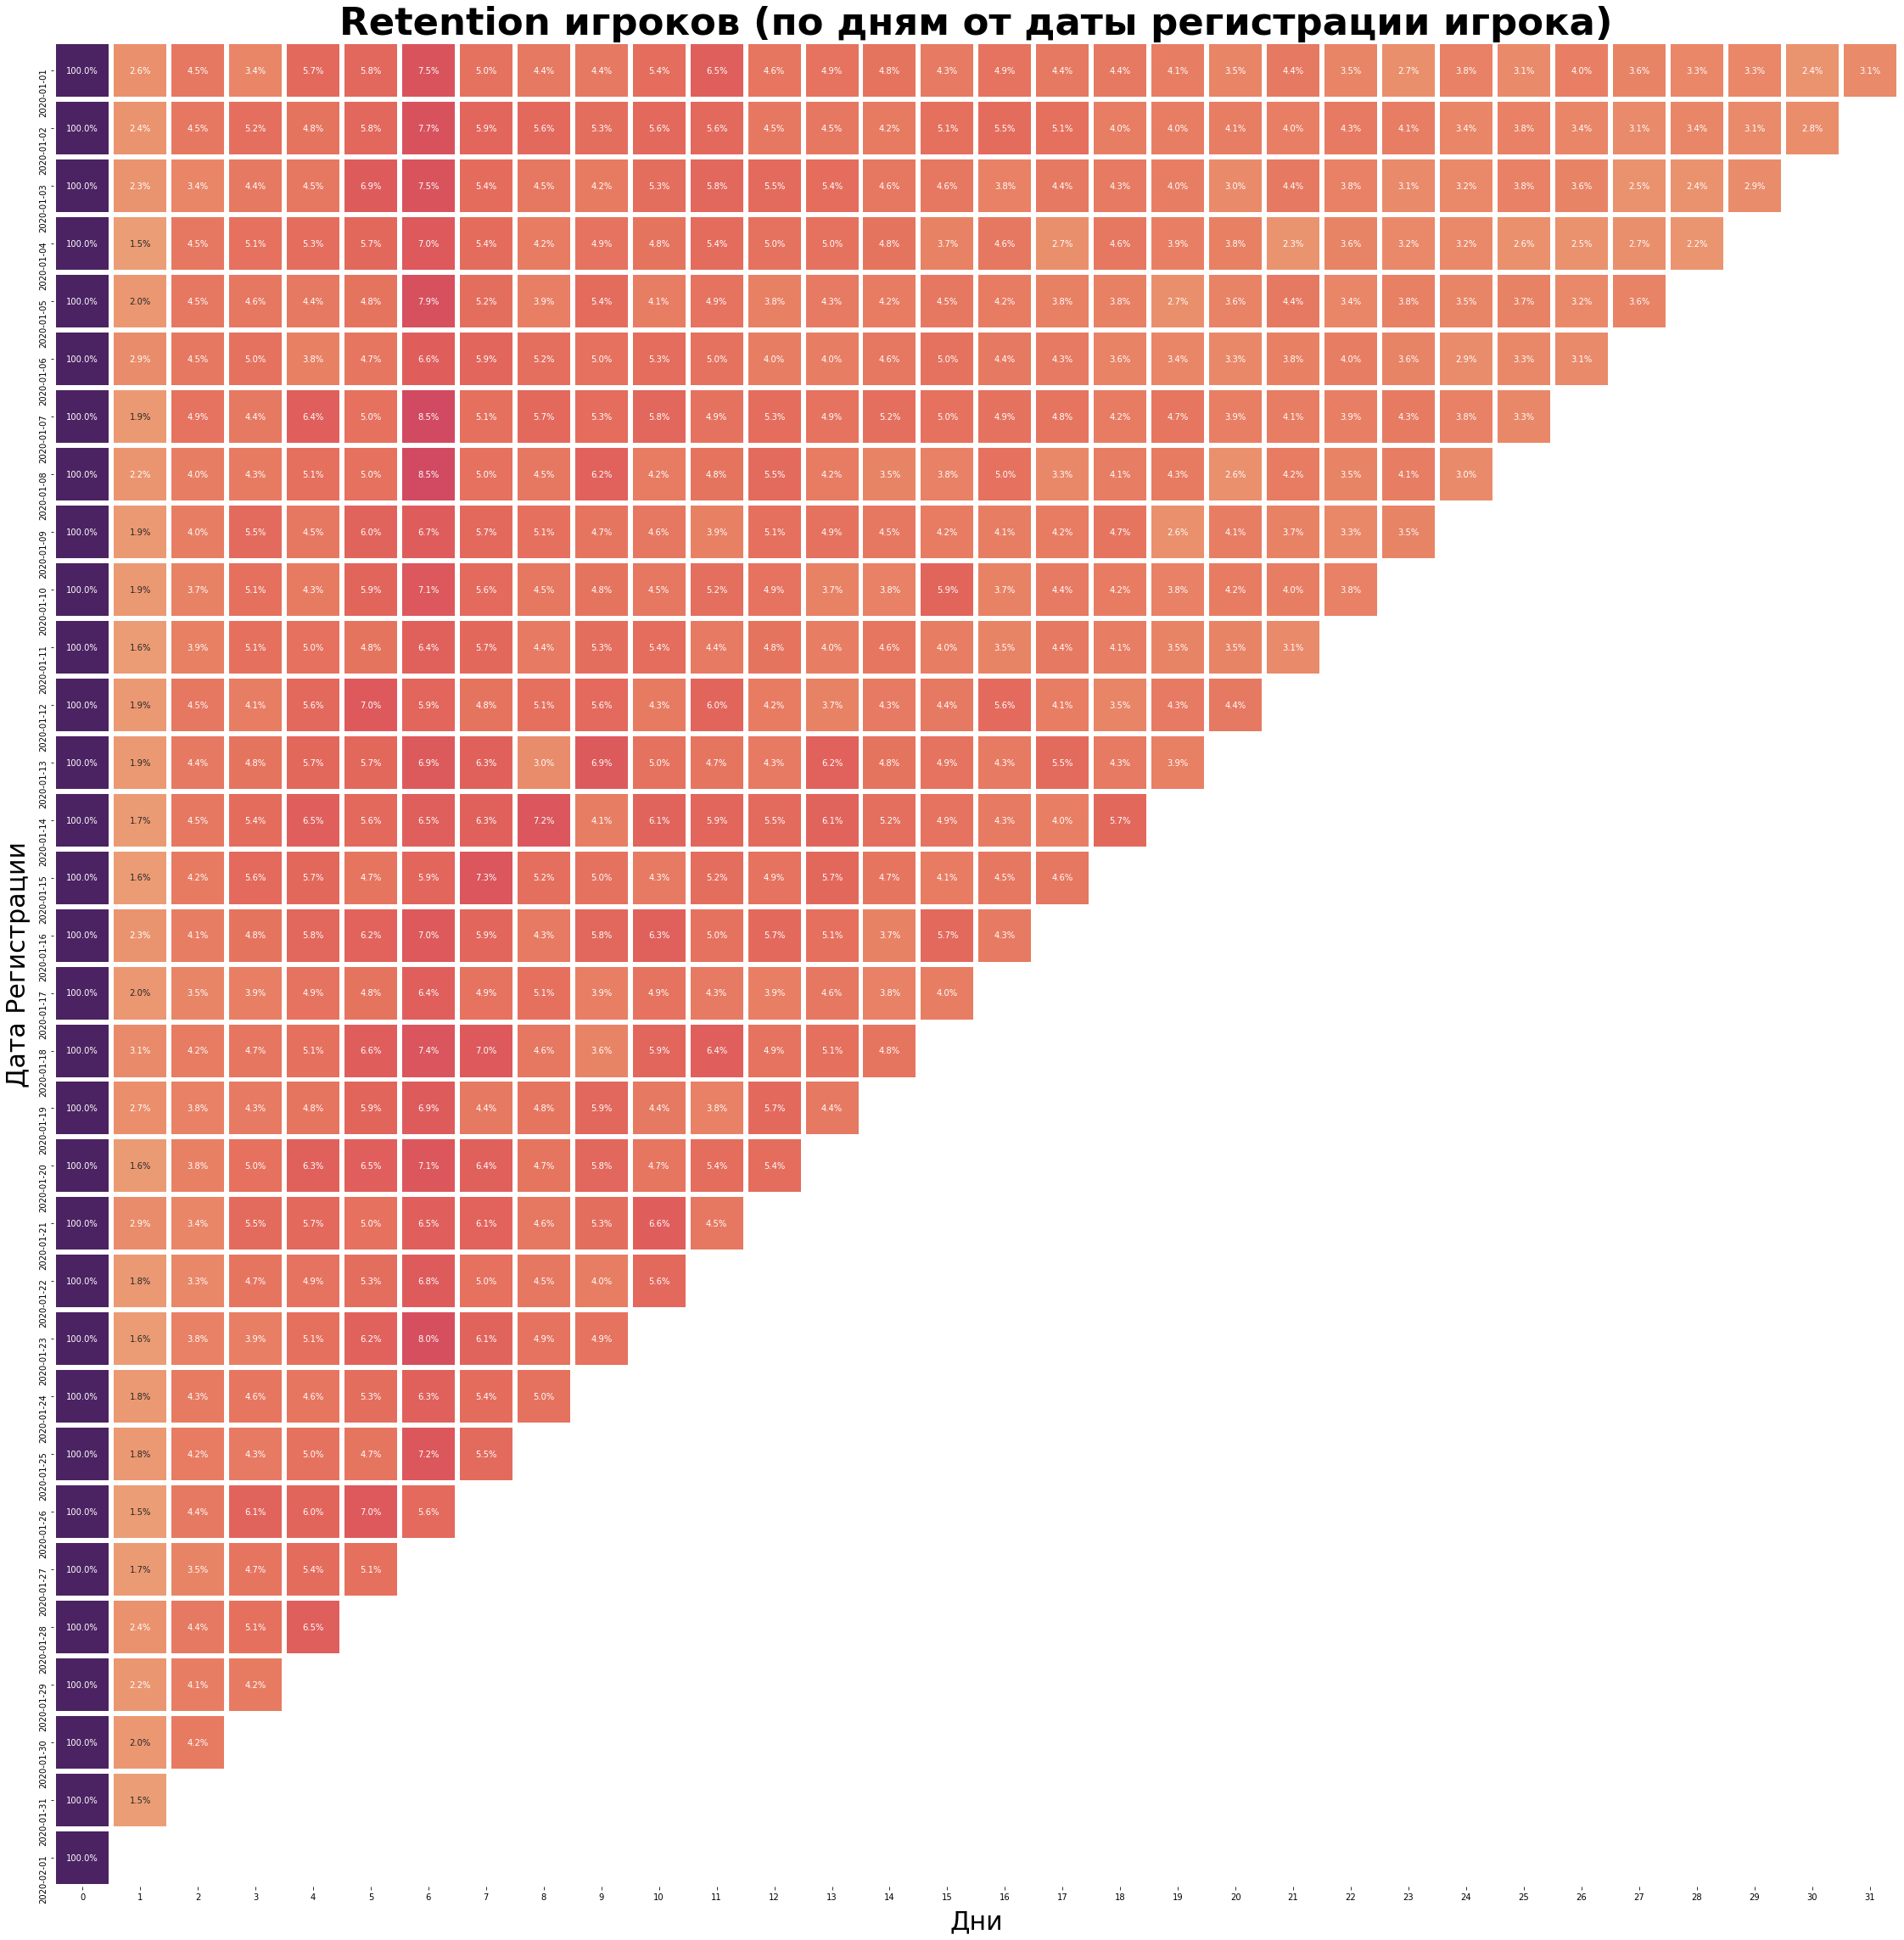

In [94]:
plt.figure(figsize=(40, 40))
plt.title('Retention игроков (по дням от даты регистрации игрока)',
              fontweight='bold', size=45)
sns.heatmap(retention_table,
                vmin=0.0,
                vmax=0.2,
                cmap='flare',
                linewidths=5,
                linecolor='white',
                fmt='.1%',
                annot=True,
                square=True,
                cbar=False)
plt.ylabel('Дата Регистрации', labelpad=10, size=30)
plt.xlabel('Дни', labelpad=10, size=30)

#### Напишем функцию:

In [182]:
def retention(df_reg, df_auth, start_date=None, end_date=None):
    """ 
    Функция подсчета Retention игроков (по дням от даты регистрации игрока)
    df_reg - датафрейм с данными о времени регистрации
    df_auth - датафрейм с данными  о времени захода пользователей в игру
    start_date - Начальный диапазон времени в формате гггг-мм-дд
    end_date - Конечный диапазон времени в формате гггг-мм-дд
    """
# Приведём время из timestamp в дату:
    df_reg['reg_dt'] = pd.to_datetime(
        df_reg.reg_ts, unit='s').dt.date
    df_auth['auth_dt'] = pd.to_datetime(
        df_auth.auth_ts, unit='s').dt.date
    
# Объединяем датафреймы и посчитаем разницу дат между регистрацией пользователя и заходом в игру:
    full_df = df_reg.merge(df_auth, on='uid')
    full_df['timedelta'] = (full_df.auth_dt - 
                            full_df.reg_dt).dt.days
    
# Период анализа:
    start_date_dt = date.fromisoformat(start_date)
    end_date_dt = date.fromisoformat(end_date)
    full_df_dt = full_df.query(
        'reg_dt >= @start_date_dt and auth_dt <= @end_date_dt')
        
# Создадим таблицу для когортного анализа, за когорты будем считать день регистрации пользователя 
# и посчитаем retention:
    cohort = (
        full_df_dt.groupby(['reg_dt','timedelta'], 
                        as_index=False)
          .agg({'uid':'nunique'})
          .pivot(index='reg_dt', 
                 columns='timedelta', 
                 values='uid')
    )
    retention_table = cohort.div(cohort[0], axis=0)
    
# Визуализируем полученные результаты:
    plt.figure(figsize=(40, 40))
    plt.title('Retention игроков (по дням от даты регистрации игрока)',
              fontweight='bold', size=45)
    sns.heatmap(retention_table,
                vmin=0.0,
                vmax=0.2,
                cmap='flare',
                linewidths=5,
                linecolor='white',
                fmt='.1%',
                annot=True,
                square=True,
                cbar=False)
    plt.ylabel('Дата Регистрации', labelpad=10, size=30)
    plt.xlabel('Дни', labelpad=10, size=30)

#### Проверим работоспособность:

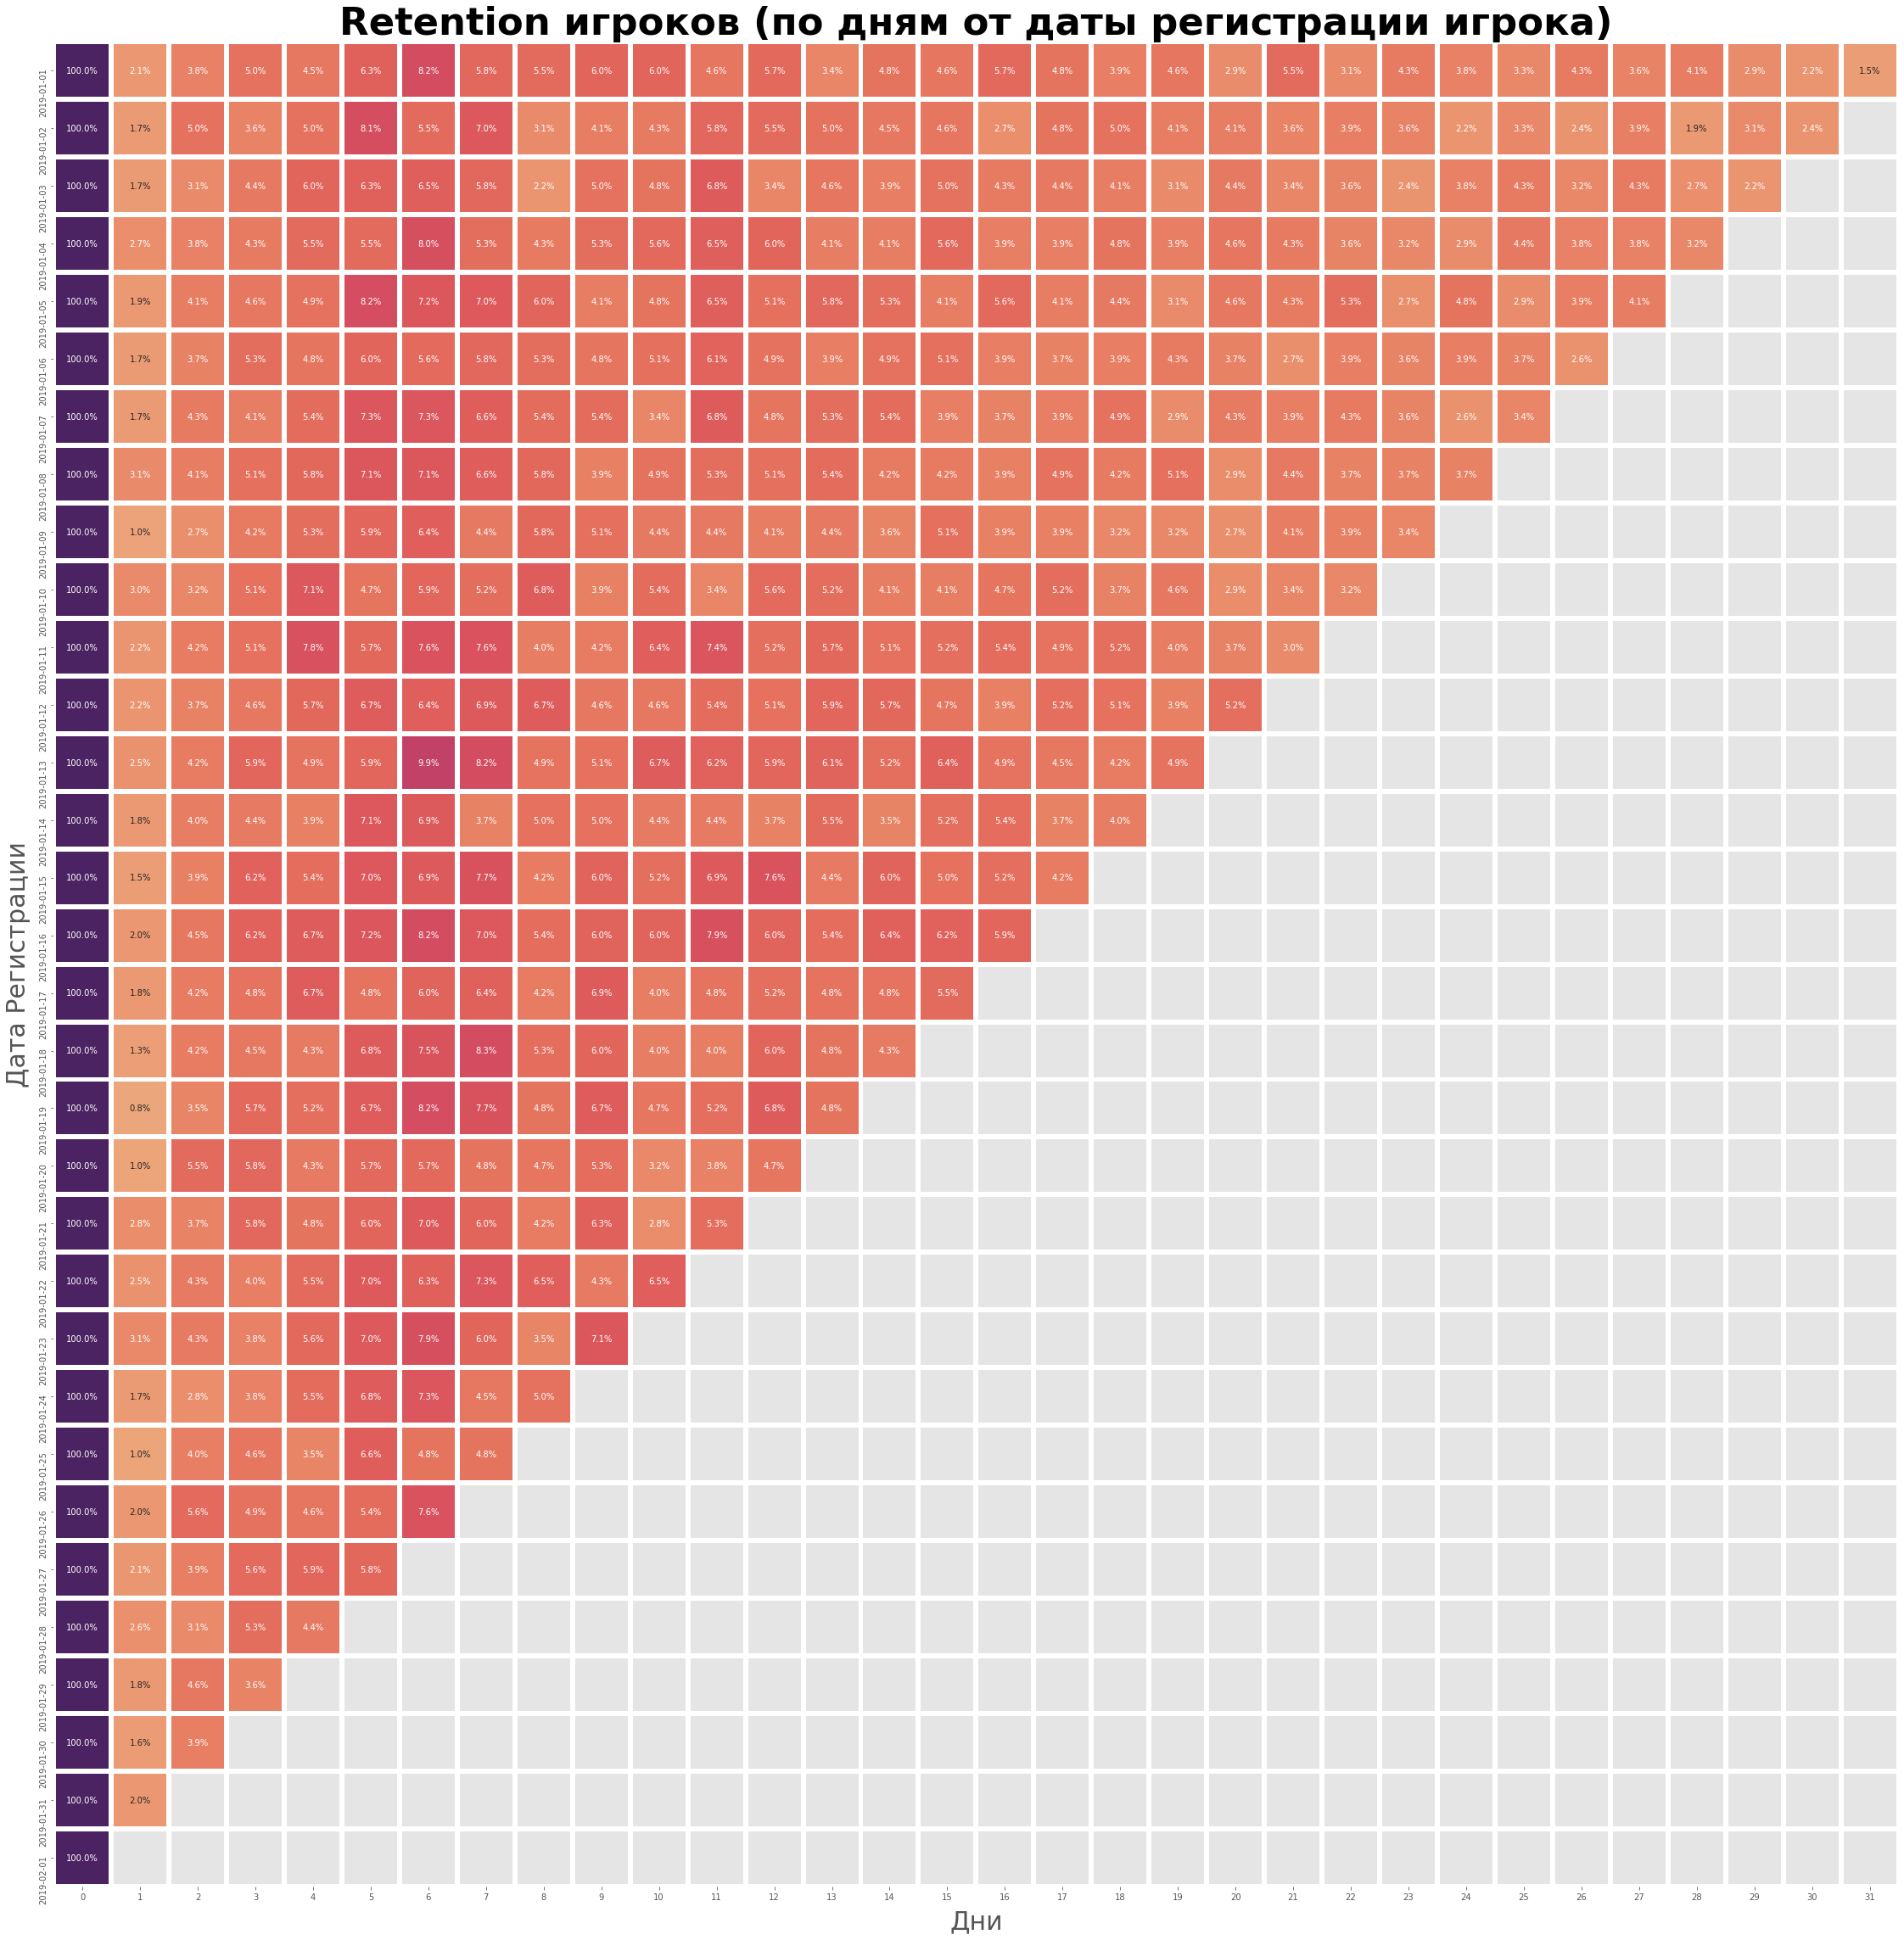

In [181]:
 retention(df_reg, df_auth, '2019-01-01', '2019-02-01')